<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water). 

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project). 

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [719]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [720]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [721]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [722]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [723]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task: 
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [724]:
for i in range(0, Nt-1):
    T[i+1] = dt * ((1/C_s)*(F(t[i]) - gamma*((T[i]) - theta[i]))) + T[i]
    theta[i+1] = dt * ((1/C_d)*(gamma*(T[i]-theta[i]))) + theta[i]

After you are finished, run the cell below to plot the results

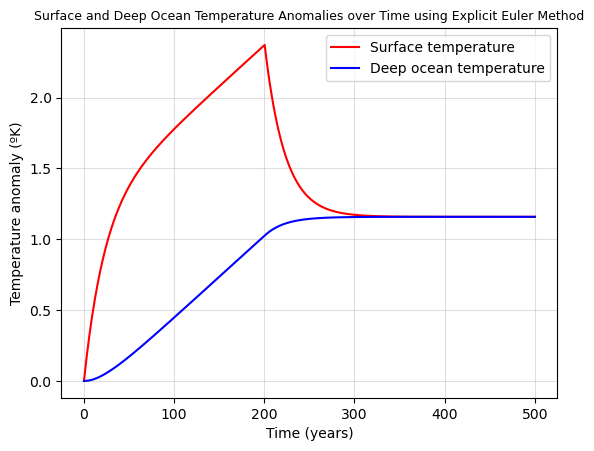

In [728]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.grid(alpha=0.4)
plt.title('Surface and Deep Ocean Temperature Anomalies over Time using Explicit Euler Method', fontsize=9)
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

Can you explain the response of T and theta to the forcing by defining charactersitcs timescales from the box model equation. 



INSERT DISCUSSION HERE (~1 paragraph)

#### Response

The rate of increase of the surface temperature is much more rapid than that of the deep ocean at the start. This matches with our expectation as the heat capacity of water is much greater than land. We can explain the observation with the charactersitic timescales. 

From scaling analysis and the solution of the diffrential equation T, which consists of an negative exponential decay factor with time, the characteristics time scale can be written as tau ~ Cd/gamma (where tau can be defined as one over the coefficient of t). Hence, from this equation we see the time scale of atmosphere and ocean is goverend by its specific heat capacity for a fixed heat exchange. For the atmosphere, tau ~ 25 years, while for the ocean tau ~ 230. The characteristic time scale of the ocean is ten times larger than the atmosphere. This tells why the ocean temperature takes so much longer to change compared to the ocean.

It is also natural for the deep ocean temperature to lag behind the surface temperature as heat need to transfer or "communicate" between them. 
After the flux has been switched off, the surface temperature droped while deep ocean temperature remained constant. This is because now the surface is transferring its energy to the deep ocean. Both reached an equilibrium at the end of the timestep 

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

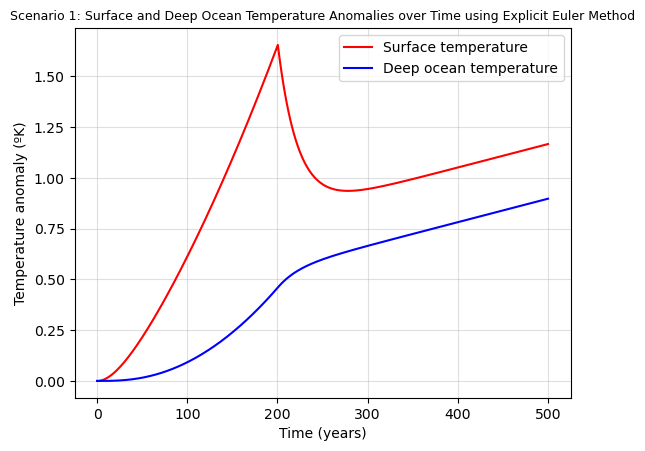

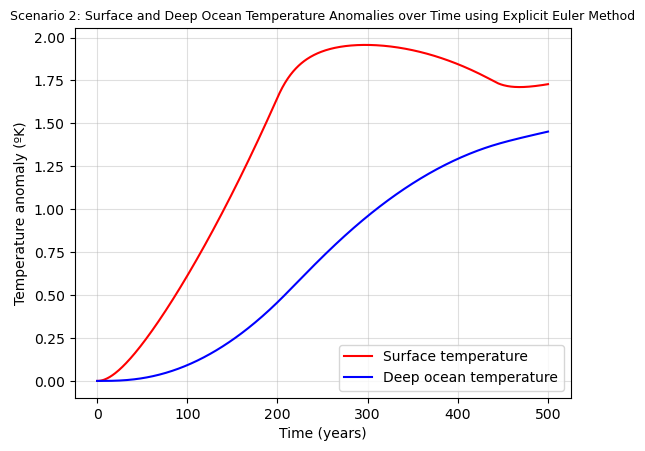

In [733]:
# Add code to make plots here
def F(t):
    return (1/200)*t if t < 200 else 0.2

Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years
for i in range(0, Nt-1):
    T[i+1] = dt * ((1/C_s)*(F(t[i]) - gamma*((T[i]) - theta[i]))) + T[i]
    theta[i+1] = dt * ((1/C_d)*(gamma*(T[i]-theta[i]))) + theta[i]

plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.grid(alpha=0.4)
plt.title('Scenario 1: Surface and Deep Ocean Temperature Anomalies over Time using Explicit Euler Method', fontsize=9)
plt.show()

def F(t):
    if t < 200:
        return (1/200)*t
    else:
        slope = 1 / (500 - 200) # Linear decrease: F(t) = 1 - slope*(t - 200)
        return max(0.2, 1 - slope * (t - 200))
    
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years
for i in range(0, Nt-1):
    T[i+1] = dt * ((1/C_s)*(F(t[i]) - gamma*((T[i]) - theta[i]))) + T[i]
    theta[i+1] = dt * ((1/C_d)*(gamma*(T[i]-theta[i]))) + theta[i]

plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.grid(alpha=0.4)
plt.title('Scenario 2: Surface and Deep Ocean Temperature Anomalies over Time using Explicit Euler Method', fontsize=9)
plt.show()

INSERT DISCUSSION HERE

#### Response



In scenario 1, the forcing increases linearly with time from 0 to 200, and then dropped to a level of constant 0.2 units. 
In scenario 2, the forcing increases linearly with time from 0 to 200, and the dropped linearly from t=200 to 500, and we assume a constant forcing of 0.2 afterwards.
In both of these cases, the temperature of both atmosphere and ocean increases non-linearly initially from 0 to 200. 

In scenario 1, the surface temperature declines sharply after t=200, responding quickly to the "switch-off" in forcing. However, the surface temperature stops falling and rises again before reaching the temperature of the ocean. This is because the rate of energy transfer from the forcing is greater than the rate of energy transfer between the land and ocean. Furthermore, heat energy need energy gradient to transfer and therefore explaianing why the temperature won't drop further. Also note that how the temperature increases linearly with time after 300, in response to a constant forcing. 

In scenario 2, the temperature change follows similarly to that of scenario 1, but after t=200, the surface temperature continues to rise and only see signs of stopping and falling back down at t=300. The land temperature at t=500 will have yet to fall to a level below the temperature at t=200. It is also interesting to see how the ocean temperature increass and take up a lot of the excess energy. 


Theses scenarios are created to simulate the future emission scenarios, where the GHGs emission dropped and the resulting forcing that will decrease with time. Scenario 2 is a more realistic case as the emission would not switch off immediately, but decreases gradually. This suggests how the response in atmosphere temperature of our climate system is very non-linear, and we would likely to observe global temperature to  continue to rise after we cut our emission (anthropogenic forcing) down.  

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [629]:
def construct_M(x):
# Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    dx = x[1] - x[0]  # Infer the uniform grid spacing
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
    M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
    return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [630]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0] 

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [631]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0] 

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)
    
    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [632]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [707]:
# Defining parameters
kappa = 0.02  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [708]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.04 seconds


and finally, plot the results side-by-side

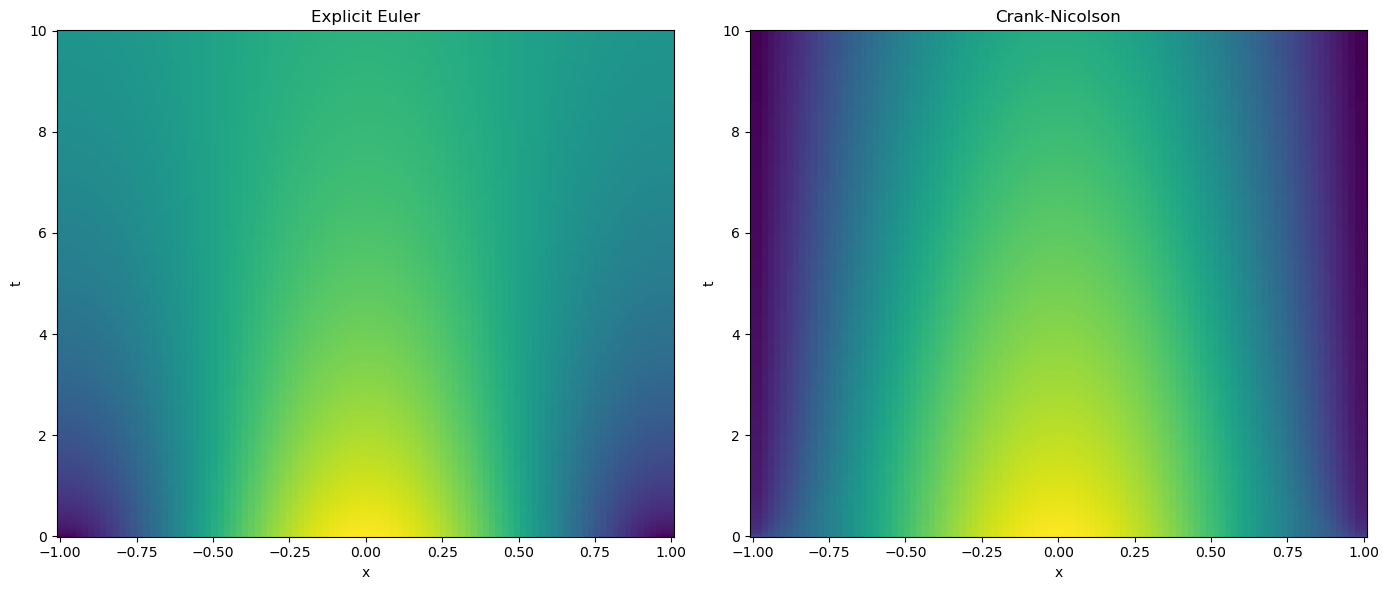

In [709]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

In [710]:
def construct_exact_solution(x, t_start, t_end, Nt, kappa):
    c_exact = np.zeros((Nx, Nt))

    t = np.linspace(t_start +10, t_end +10, Nt) # add 10 to match the IC time of the EE and CN schemes
    
    c_exact[:, 0] = set_ics(x, kappa, t_start + 10)  # Set the initial condition
    for i, value in enumerate(t[1:]):
        c_exact[:, i + 1] = (4*np.pi*kappa*value)**(-0.5)*np.exp(-x**2 / (4*kappa*value))
    return c_exact

c_exact = construct_exact_solution(x, t_start, t_end, Nt, kappa)

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).



INSERT COMMENTS HERE

#### Response
When diffusivity is increased to 0.01 from 0.001, both method are sensible and they show similar profile of high value in the centre diffusing to the edge.  
When diffusivity is increased to above 0.02, the solution for the Explicit Euler becomes unreasonable when comapared to the Crank-Nicolson solution. Though without posteriori knowledge of the exact solution/ expected behaviour, it is likely that we wouldn't be able to tell the solution deviates and is unreasonable at this stage. 
When diffusivity is increasesd further form this threshold, the Explicit Euler solution become unbounded, which is a sign of error that has grown exponentially and overwheled the true solution. The Crank-Nicolson method remains reliable.

This matches with out expectation that Crank-Nicolson method is unconditionally stable, while Explicit Euler is only conditionally stable, with one of the conditions being diffusivity in the diffusion equation.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

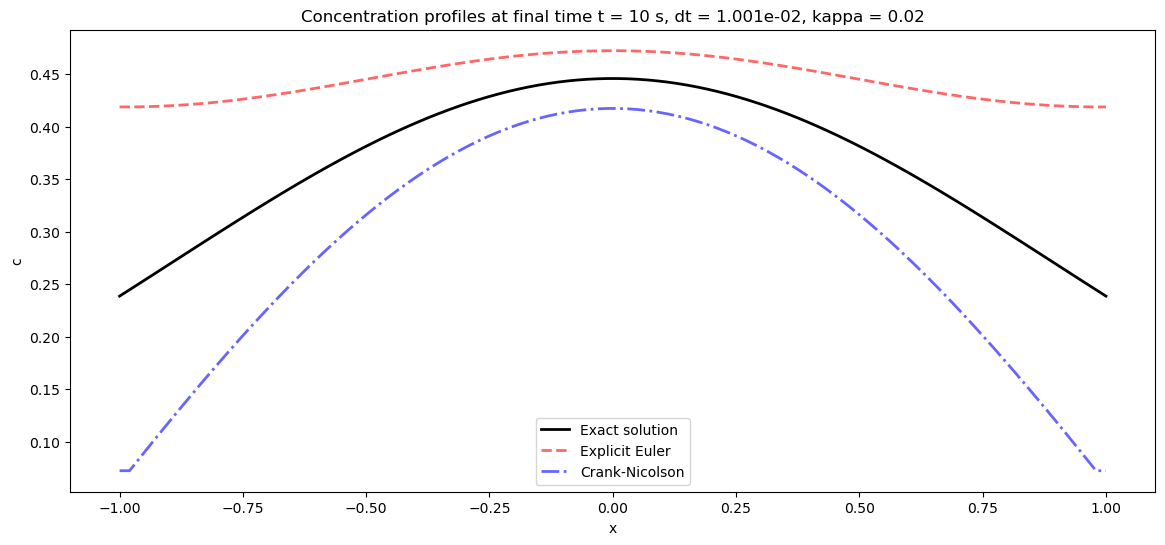

In [711]:
dt = t[2] - t[1]

plt.figure(figsize=(14, 6))
plt.plot(x, c_exact[:, -1], 'k-', label='Exact solution', linewidth=2, alpha=1)
plt.plot(x, c_EE[:, -1], 'r--', label='Explicit Euler', linewidth=2, alpha=0.6)
plt.plot(x, c_CN[:, -1], 'b-.', label='Crank-Nicolson', linewidth=2, alpha=0.6)
plt.xlabel('x')
plt.ylabel('c')
plt.title(f'Concentration profiles at final time t = {t[-1]:.3g} s, dt = {dt:.3e}, kappa = {kappa}')
plt.legend()
plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

In [712]:
number_of_time_steps_to_try = [i for i in range(1000, 5000, 100)]
errors_EE = []
errors_CN = []
dt = []

for Nt in number_of_time_steps_to_try:
    t = np.linspace(t_start, t_end, Nt)
    c_EE = EE(x, t, kappa) # explicit Euler
    c_CN = CN(x, t, kappa) # Crank-Nicolson
    c_exact = construct_exact_solution(x, t_start, t_end, Nt, kappa)
    error_EE = np.abs(c_EE[:, -1] - c_exact[:, -1]) # Take the errors at the last time step
    error_CN = np.abs(c_CN[:, -1] - c_exact[:, -1]) # Take the errors at the last time step

    errors_EE.append(np.mean(error_EE[:]))
    errors_CN.append(np.mean(error_CN[:]))
    dt.append(t[1] - t[0])

Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.04 seconds


[]

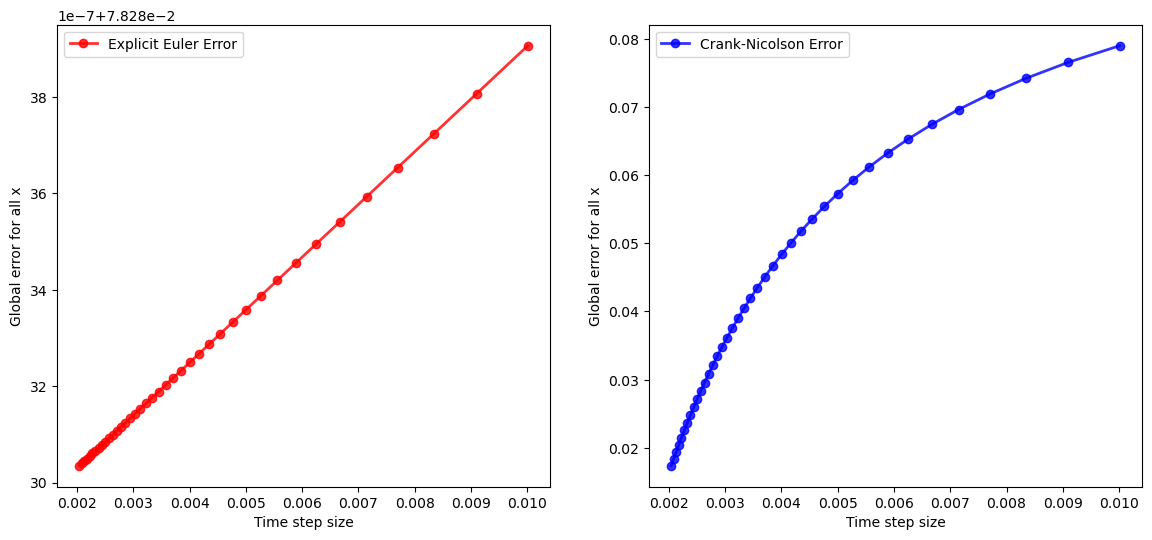

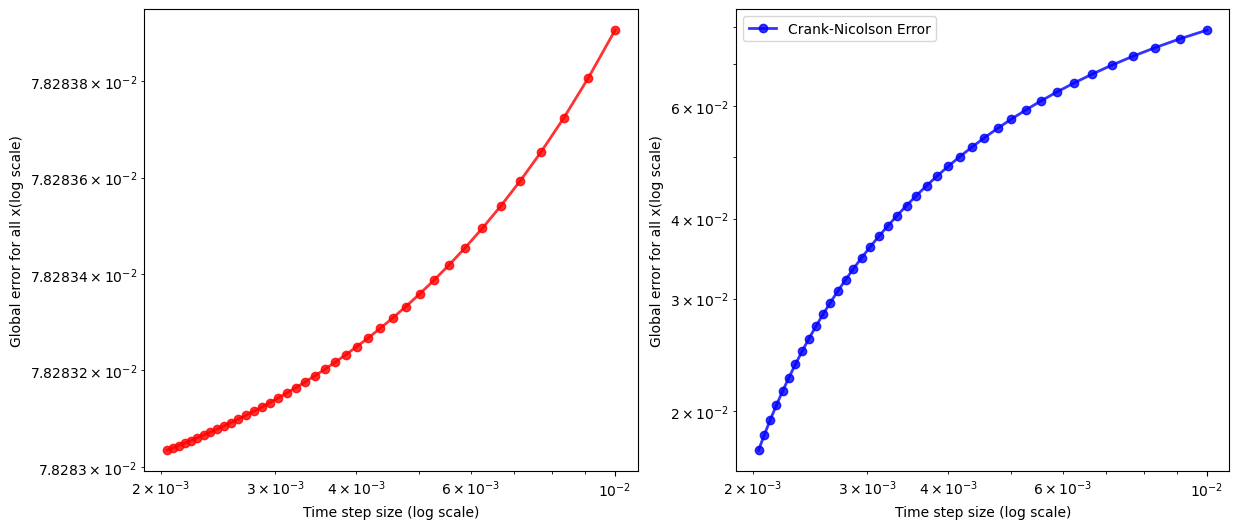

In [713]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(dt, errors_EE, 'r-o', label='Explicit Euler Error', linewidth=2, alpha=0.8)
plt.legend()
plt.xlabel('Time step size')
plt.ylabel('Global error for all x')

plt.subplot(1, 2, 2)
plt.plot(dt, errors_CN, 'b-o', label='Crank-Nicolson Error', linewidth=2, alpha=0.8)
plt.legend()
plt.xlabel('Time step size')
plt.ylabel('Global error for all x')



plt.plot()


# log log plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.loglog(dt, errors_EE, 'r-o', label='Explicit Euler Error', linewidth=2, alpha=0.8)
plt.xlabel('Time step size (log scale)')
plt.ylabel('Global error for all x(log scale)')
plt.subplot(1, 2, 2)
plt.loglog(dt, errors_CN, 'b-o', label='Crank-Nicolson Error', linewidth=2, alpha=0.8)
plt.xlabel('Time step size (log scale)')
plt.ylabel('Global error for all x(log scale)')
plt.legend()

plt.legend()
plt.plot()

In [714]:
errors_EE

[np.float64(0.07828390576835013),
 np.float64(0.07828380619916936),
 np.float64(0.07828372324258284),
 np.float64(0.07828365306113402),
 np.float64(0.0782835929147866),
 np.float64(0.07828354079480508),
 np.float64(0.07828349519504059),
 np.float64(0.07828345496399863),
 np.float64(0.07828341920625541),
 np.float64(0.07828338721502362),
 np.float64(0.07828335842496524),
 np.float64(0.07828333237849018),
 np.float64(0.07828330870125576),
 np.float64(0.0782832870840582),
 np.float64(0.0782832672692557),
 np.float64(0.07828324904044968),
 np.float64(0.07828323221455084),
 np.float64(0.07828321663560615),
 np.float64(0.0782832021699522),
 np.float64(0.07828318870237048),
 np.float64(0.07828317613301122),
 np.float64(0.07828316437491314),
 np.float64(0.07828315335199057),
 np.float64(0.07828314299738301),
 np.float64(0.07828313325210005),
 np.float64(0.07828312406389437),
 np.float64(0.07828311538632565),
 np.float64(0.07828310717797692),
 np.float64(0.0782830994017927),
 np.float64(0.07828

#### Discussion 

#### Response

It can be seen that the error profile and error variation depends on a lot of factors (kappa, dx, the range of time step considered, the x index considered) and cannot be described in 2 to 3 paragraphs. 
The error profile of the solution varies and even flips sign depends on how far away you are from the center, though it is symmetrical about x=0. 

For the timestep range of between 0.002 to 0.01 (number of time steps between 1000 to 5000), kappa of 0.02, considering the average erros across all discretised space:
The explicit Euler scheme global error decreases with decreasing step size. However, the global error does not reduce by a factor of 1/2 by halving the time step size. Given that the Explicit Euler is theorhetically first order accurate globally, this is not expected.

The Crank-Nicolson global error also decreases with decreasing step size, but the curve on normal and log-log scale appears to convex downward. The global error tends towards decreasing quadratically with step size, but not quite reaching the level. This might be because of the way we averaged the error profile across all x, resulting in an inaccurate representation of the error. One might also postulate the discrepency might be due to the spatial discretisation in the code. We used in first order spatial discretisation, which might be causing the error.


Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.04 seconds


[]

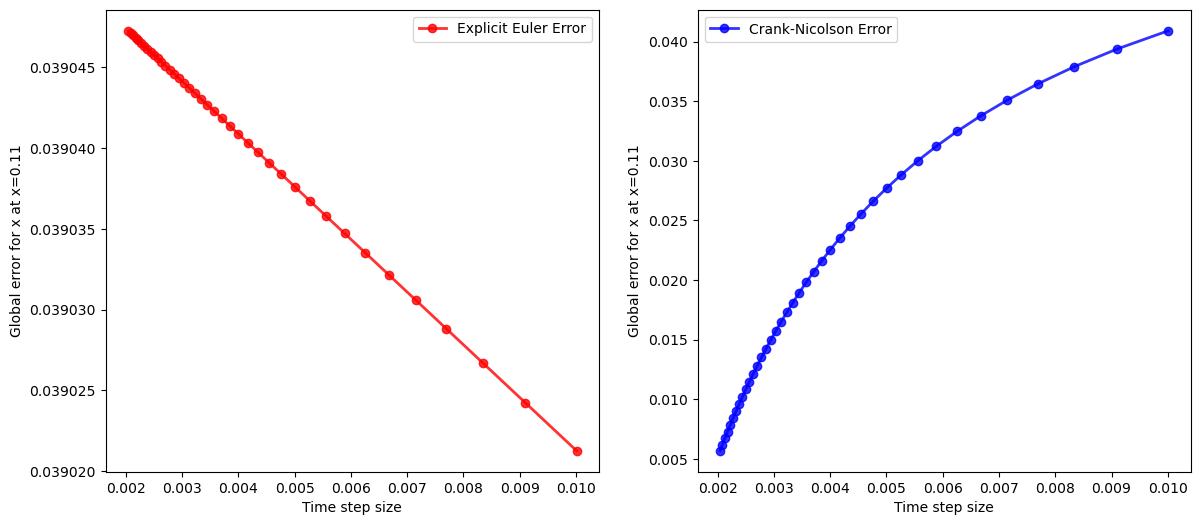

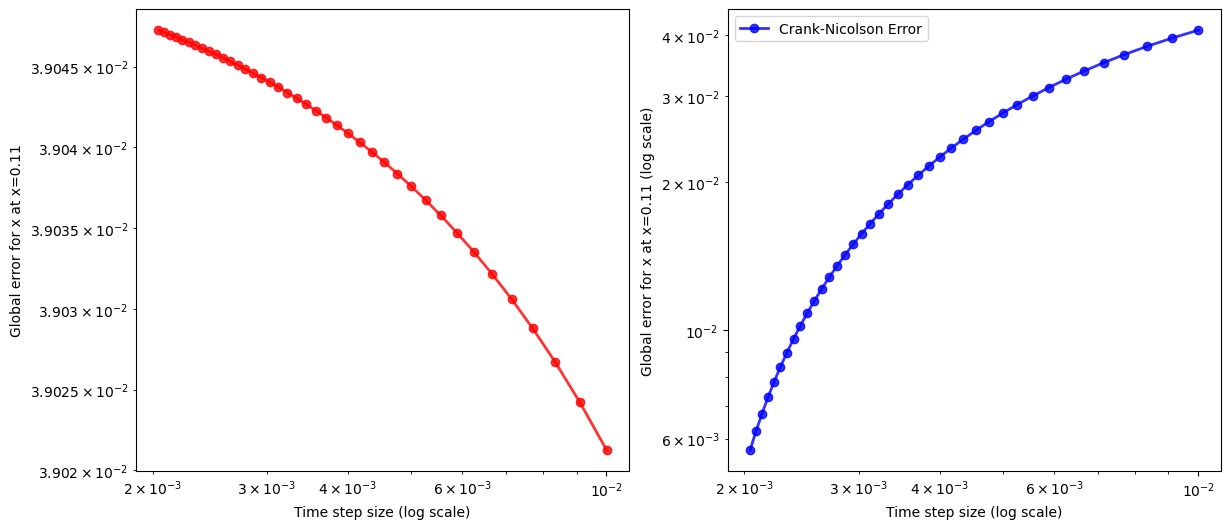

In [735]:
t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

number_of_time_steps_to_try = [i for i in range(1000, 5000, 100)]
errors_EE = []
errors_CN = []
dt = []

for Nt in number_of_time_steps_to_try:
    t = np.linspace(t_start, t_end, Nt)
    c_EE = EE(x, t, kappa) # explicit Euler
    c_CN = CN(x, t, kappa) # Crank-Nicolson
    c_exact = construct_exact_solution(x, t_start, t_end, Nt, kappa)
    error_EE = np.abs(c_EE[:, -1] - c_exact[:, -1]) # Take the errors at the last time step
    error_CN = np.abs(c_CN[:, -1] - c_exact[:, -1]) # Take the errors at the last time step

    errors_EE.append(np.mean(error_EE[35]))
    errors_CN.append(np.mean(error_CN[35]))
    dt.append(t[1] - t[0])

# Get the 55th index of x
x_55 = x[55]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(dt, errors_EE, 'r-o', label='Explicit Euler Error', linewidth=2, alpha=0.8)
plt.legend()
plt.xlabel('Time step size')
plt.ylabel(f'Global error for x at x={x_55:.2f}')

plt.subplot(1, 2, 2)
plt.plot(dt, errors_CN, 'b-o', label='Crank-Nicolson Error', linewidth=2, alpha=0.8)
plt.legend()
plt.xlabel('Time step size')
plt.ylabel(f'Global error for x at x={x_55:.2f}')



plt.plot()


# log log plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.loglog(dt, errors_EE, 'r-o', label='Explicit Euler Error', linewidth=2, alpha=0.8)
plt.xlabel('Time step size (log scale)')
plt.ylabel(f'Global error for x at x={x_55:.2f}')
plt.subplot(1, 2, 2)
plt.loglog(dt, errors_CN, 'b-o', label='Crank-Nicolson Error', linewidth=2, alpha=0.8)
plt.xlabel('Time step size (log scale)')
plt.ylabel(f'Global error for x at x={x_55:.2f} (log scale)')
plt.legend()

plt.legend()
plt.plot()


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

#### Response 

Suppose we consider the average error across all x grids (the first set of plots), we choose an arbitrary error tolerance of 0.07832, then dt for CN scheme is 0.009 and for the EE scheme is about 0.0035. The result shows that the Crank-Nicolson method took a shorter time to complete and therefore is more efficient at generating solutions with error less than the set error tolerance across all x.  

In [736]:
time_steps_CN = round(10/0.009)
time_steps_EE = round(10/0.0035)

t = np.linspace(t_start, t_end, time_steps_EE)  # Create a vector of times

c_EE = EE(x, t, kappa) # explicit Euler

t = np.linspace(t_start, t_end, time_steps_CN)  # Create a vector of times

c_CN = CN(x, t, kappa) # Crank-Nicolson


Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.04 seconds


/opt/miniconda3/envs/hk_regime/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/miniconda3/envs/hk_regime/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

#### Response
The first row and last row of coefficient matrix M_d is modified such that the coefficients of implicit and explicit terms in the Crank-Nicolson method now can be subjected to the boundary conditions correctly, instead of modifying them after each C-N update. Please see the below cell the boundary conditions are enforced by the modified M_d matrix and therefore the update after each C-N update is removed. The resulting change is obvious, with the C-N solution profile looking similar to the exact solution, especially when the boundary effect is felt, which is in our case.

The modified matrix M_d is plotted below. Here the first row and last row coefficients for the edge points are set to 1, while other points set to 0. This allows the boundary conditions (vector on the right hand side) to be enforced to c0 and cN, where N=99 and both points are at the boundary. Note that the 1/dx factor is embeded inside the CN algorithm and so not needed in M. 


In [747]:
#ADD CODE AND PLOTS HERE
#If we want no flux in the boundary, but taking in mind conservation of mass. Apply Neumann conditions. 

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

M_c = construct_M(x) 
# Modify M for no flux boundary conditions and Nuemann BCs
M_c[0,0] = M_c[0,0] + M_c[0,1] 
M_c[-1,-1] = M_c[-1,-1] + M_c[-1,-2] 

# For our case, our exact solution dipicts the unbounded diffusion equation, so heat is allowed to escape
# out of the boundaries.

M_d = construct_M(x)
# Modify M for unbounded case
M_d[0,0] = 1
M_d[0,1] = 0
M_d[-1,-1] = 1
M_d[-1,-2] = 0

In [748]:
def CN(x, t, kappa, M_d):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0] 

    M = M_d

    # Modify M for no flux boundary conditions and Nuemann BCs

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)
    
    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme

    show_idx = (0, 5)
    
    plt.matshow(A.toarray(), vmin=-5, vmax=5)
    plt.ylim(show_idx)
    plt.xlim(show_idx)
    plt.title('Matrix A in Crank-Nicolson Scheme')

    # Display the value of each cell on the plot
    for (i, j), val in np.ndenumerate(A[show_idx[0]:show_idx[1]].toarray()):
        if abs(val) > 1e-10:  # Only display non-zero values for clarity
            plt.text(j, i, f'{val:.0f}', ha='center', va='center', color='white' if abs(val) > 2000 else 'black')

    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1])) # Here , the dimension of c is [x, time]
        # The boundary conditions are enforced by the modified M_d matrix and therefore no update is needed here.

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Explicit Euler method took 0.16 seconds


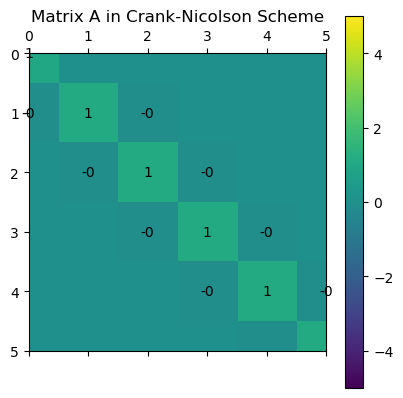

/opt/miniconda3/envs/hk_regime/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/miniconda3/envs/hk_regime/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.21 seconds


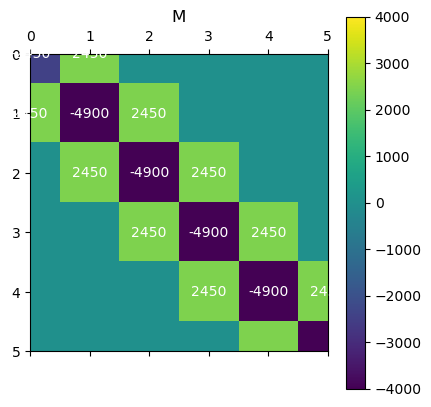

In [749]:
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa, M_d) # Crank-Nicolson
c_exact = construct_exact_solution(x, t_start, t_end, Nt, kappa)

show_idx = (0,5)

plt.matshow(M_c.toarray(), vmin=-4000, vmax=4000)
plt.title('M')
plt.ylim(show_idx)
plt.xlim(show_idx)

# Display the value of each cell on the plot
for (i, j), val in np.ndenumerate(M_c[show_idx[0]:show_idx[1]].toarray()):
    if abs(val) > 1e-10:  # Only display non-zero values for clarity
        plt.text(j, i, f'{val:.0f}', ha='center', va='center', color='white' if abs(val) > 2000 else 'black')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

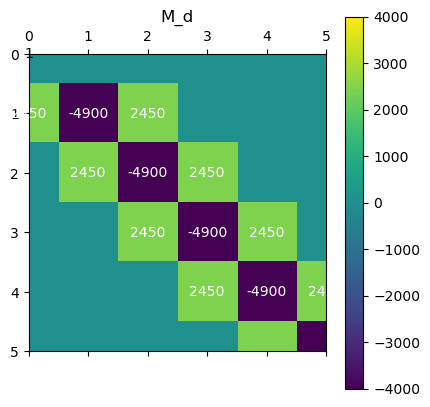

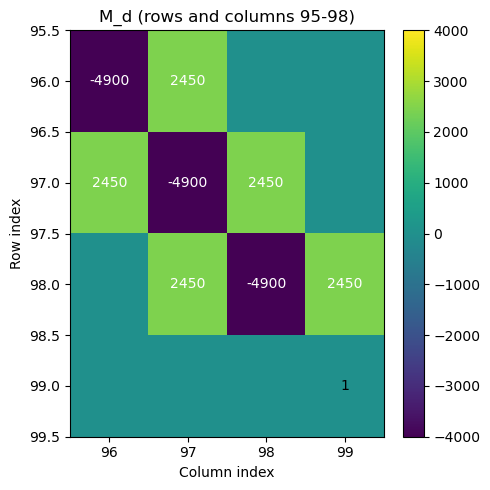

In [761]:
show_idx = (0, 5)
plt.matshow(M_d.toarray(), vmin=-4000, vmax=4000)
plt.title('M_d')
plt.ylim(show_idx)
plt.xlim(show_idx)

# Display the value of each cell on the plot
for (i, j), val in np.ndenumerate(M_d[show_idx[0]:show_idx[1]].toarray()):
    if abs(val) > 1e-10:  # Only display non-zero values for clarity
        plt.text(j, i, f'{val:.0f}', ha='center', va='center', color='white' if abs(val) > 2000 else 'black')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

show_idx = (96, 100)
M_subset = M_d[show_idx[0]:show_idx[1], show_idx[0]:show_idx[1]].toarray()

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(M_subset, vmin=-4000, vmax=4000, 
               extent=[show_idx[0]-0.5, show_idx[1]-0.5, show_idx[1]-0.5, show_idx[0]-0.5],
               aspect='auto', origin='upper')
ax.set_title('M_d (rows and columns 95-98)')
ax.set_xlabel('Column index')
ax.set_ylabel('Row index')

# Display the value of each cell
for i in range(M_subset.shape[0]):
    for j in range(M_subset.shape[1]):
        val = M_subset[i, j]
        if abs(val) > 1e-10:
            ax.text(show_idx[0] + j, show_idx[0] + i, f'{val:.0f}', 
                   ha='center', va='center', 
                   color='white' if abs(val) > 2000 else 'black')

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

#### Response
Above shows the first and last few rows of the modified coefficient matrix M_d. Blank entries indicate a value of 0. 

Number of time steps {4900}


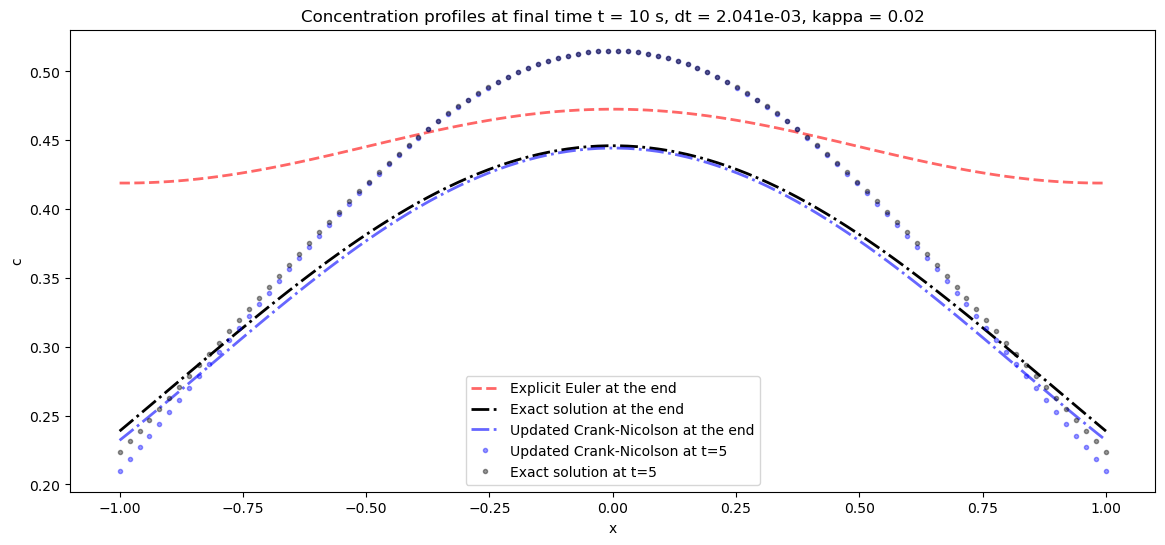

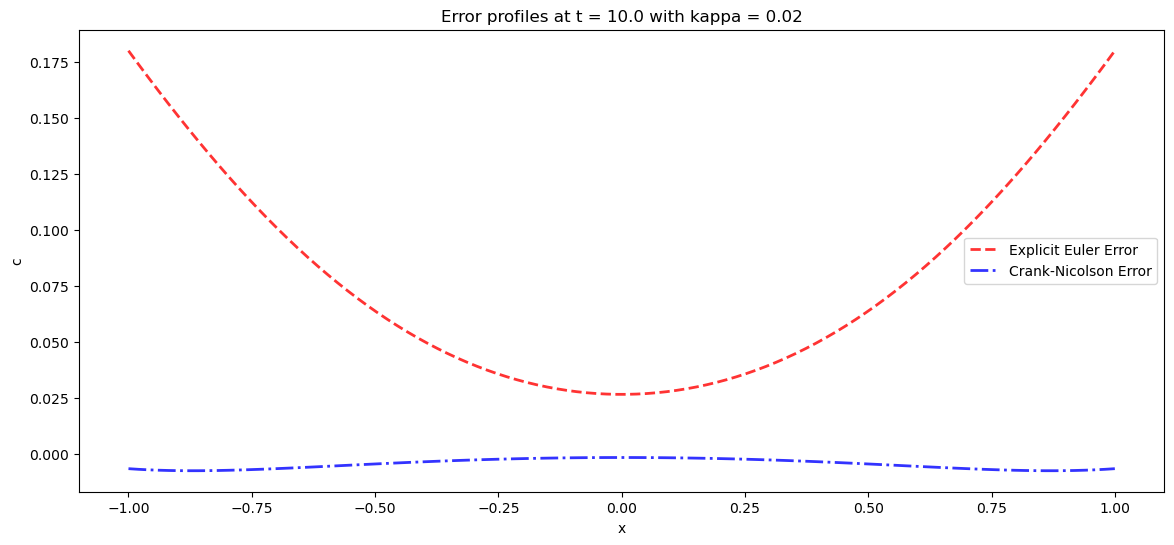

In [769]:
# Plot solution profile
dt = t[1] - t[0]

print(f"Number of time steps", {c_CN.shape[1]})

plt.figure(figsize=(14, 6))
plt.plot(x, c_EE[:, -1], 'r--', label='Explicit Euler at the end', linewidth=2, alpha=0.6)
plt.plot(x, c_exact[:, -1], 'k-.', label='Exact solution at the end', linewidth=2, alpha=1)
plt.plot(x, c_CN[:, -1], 'b-.', label='Updated Crank-Nicolson at the end', linewidth=2, alpha=0.6)
plt.plot(x, c_CN[:, -490*5], 'b.', label='Updated Crank-Nicolson at t=5', linewidth=2, alpha=0.4)
plt.plot(x, c_exact[:, -490*5], 'k.', label='Exact solution at t=5', linewidth=2, alpha=0.4)
plt.xlabel('x')
plt.ylabel('c')
plt.title(f'Concentration profiles at final time t = {t[-1]:.3g} s, dt = {dt:.3e}, kappa = {kappa}')
plt.legend()
plt.show()

# Add code to plot error here
# Plot errors 
plt.figure(figsize=(14, 6))

plt.plot(x, c_EE[:, -1] - c_exact[:, -1], 'r--', label='Explicit Euler Error', linewidth=2, alpha=0.8)
plt.plot(x, c_CN[:, -1] - c_exact[:, -1], 'b-.', label='Crank-Nicolson Error', linewidth=2, alpha=0.8)
plt.xlabel('x')
plt.ylabel('c')
plt.title(f'Error profiles at t = {t[-1]} with kappa = {kappa}')
plt.legend()
plt.show()

#### Response

Above shows the solution profile at t=5 and at t=10 for the Crank-Nicolson method and exact solution. It can be seen that at the boundary, the C-N solution still follows closely to the exact solution, unlike the original Crank-Nicolson solution earlier in the script. 

ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)

For fixed value (Dirichlet) boundary conditions, we can enforce the value of c at the boundary to the coefficient matrix M in the Crank-Nicolson update scheme. Given the boundary values at each time steps i.e. c(0,t) and c(N,t), we can then equate LHS (M times vector of updated time-step c) and RHS (vector of previous time-step c). The right hand side is continuously updated as the solution evolves. 

For fixed gradient (Neumann) boundary conditions, given the gradient at the boundary, we then have to use first order finite approximation, rearranging giving c(0,t) - c(1,t)/(1+dx) = 0 and -c(N,t) = c(N-1,t)/(1+dx). Again, we will have to modify the coefficient matrix M to reflect the changes. 
For no-flux boundary, the coefficients are worked out to be (2+a), -a for the first row first two column in M, where a=(kappa*dt/(dx)**2). The last row last two column in M are (2+a), -a respectively. This should follow conservation of mass and no-flux boundary condition.

However, this will turn the method into first order accurate globally. 
